# 04a_modality_usage_ct.ipynb  
**Diagnostic Modality Analysis – CT Usage by Demographics and Procedure Type**

---

### **Aim**
This notebook analyses **Computed Tomography (CT)** usage across key demographics (`age_band`, `gender`) and procedure classifications (e.g. **head**, **chest**, **abdomen**, **angiography**).

Aligned with the `04b` (MRI), and `04c` (Endoscopy) format, this notebook provides:
- Frequency counts of common CT procedures  
- Crosstab breakdowns by `age_band × anatomical_group`  
- Density and bar plots of age-modality distributions  
- Referral type and patient source matrices  
    
---

### **Purpose**
To understand demographic drivers of CT demand, supporting elective diagnostic service modelling by identifying high-volume anatomical groups and pathway types.

---

### **Output**
- Ranked CT procedure categories  
- Age-based usage visualisations  
- Referral-source interaction tables  
- Inputs for future LSOA-level geospatial demand modelling  

---

### **Notes**
- Cancer-specific indicators are excluded (non-oncology focus)  
- Uses anatomy classification mapping from `procedure_name → anatomical_group`  
- Consistent with the 04x-series design pattern, feeding into 04e (MRI deep-dive)  

---


Imports & Raw-Folder Ingestion

In [13]:
# ---------------------------------------------------
# 0 – Imports & Raw-Folder Ingestion
# ---------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib as plt
import os
import glob
import re
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# ----------- 1A. Point to your raw folder OR hard-code the list ----------
raw_dir   = "/Users/rosstaylor/Downloads/Research Project/Code Folder/nhs-diagnostics-dids-eda/nhs-dids-explorer/data/raw/2024 NHS SW ICBs"
csv_files = glob.glob(os.path.join(raw_dir, "*.csv"))

if not csv_files:
    raise FileNotFoundError("csv_files list is empty – check raw_dir or paths")

print(f"Detected {len(csv_files)} files")

# ----------- canonical 23-column schema from the SQL query ---------------
expected_cols = [
    'icb_code','icb_name','lsoa_code','nhs_region',
    'site_code','site_name','provider_code','provider_name',
    'activity_month','financial_year','financial_month','test_date',
    'age','sex','modality','sub_modality','procedure_name',
    'referral_type','patient_source','cancer_flag','subcancer_flag',
    'referring_org_code','referring_org_name'
]

dfs, meta = [], []
for fp in csv_files:
    peek = pd.read_csv(fp, nrows=5)
    if not set(expected_cols).issubset(peek.columns):
        print(f" {os.path.basename(fp)} – no header found, re-loading with names")
        df_tmp = pd.read_csv(fp, header=None, names=expected_cols, low_memory=False)
    else:
        df_tmp = pd.read_csv(fp, low_memory=False)

    df_tmp = df_tmp.dropna(axis=1, how='all')
    df_tmp.columns = df_tmp.columns.str.strip().str.lower()
    df_tmp = df_tmp[[c for c in expected_cols if c in df_tmp.columns]]
    for col in (set(expected_cols) - set(df_tmp.columns)):
        df_tmp[col] = pd.NA
    df_tmp = df_tmp[expected_cols]
    dfs.append(df_tmp)

    meta.append({
        "file": os.path.basename(fp),
        "rows": len(df_tmp),
        "cols": df_tmp.shape[1],
        "MB": round(df_tmp.memory_usage(deep=True).sum()/1e6, 2)
    })

meta_df = pd.DataFrame(meta)
display(meta_df.style.set_caption("Loaded files – rows / cols / size"))

df = pd.concat(dfs, ignore_index=True)
print(f"Combined shape: {df.shape}")  # expect ~4 M × 23

# Basic type coercion
df["age"] = pd.to_numeric(df["age"], errors="coerce")
df["test_date"] = pd.to_datetime(df["test_date"], errors="coerce")
df["activity_month"] = pd.to_datetime(
    df["activity_month"].astype(str), format="%Y%m", errors="coerce"
)


Detected 7 files
 2024_NHS_SW_Somerset_ICB_11X.csv – no header found, re-loading with names
 2024_NHS_SW_Cornwall_ICB_11N.csv – no header found, re-loading with names
 2024_NHS_SW_Gloucestershire_ICB_11M.csv – no header found, re-loading with names
 2024_NHS_SW_Dorset_ICB_11J.csv – no header found, re-loading with names
 2024_NHS_SW_Devon_ICB_15N.csv – no header found, re-loading with names
 2024_NHS_SW_BSW_ICB_92G.csv – no header found, re-loading with names
 2024_NHS_SW_BNSSG_ICB_15C.csv – no header found, re-loading with names


,file,rows,cols,MB
0,2024_NHS_SW_Somerset_ICB_11X.csv,481843,23,695.270000
1,2024_NHS_SW_Cornwall_ICB_11N.csv,512857,23,748.350000
2,2024_NHS_SW_Gloucestershire_ICB_11M.csv,229186,23,335.490000
3,2024_NHS_SW_Dorset_ICB_11J.csv,525091,23,762.790000
4,2024_NHS_SW_Devon_ICB_15N.csv,676563,23,991.610000
5,2024_NHS_SW_BSW_ICB_92G.csv,741719,23,1106.540000
6,2024_NHS_SW_BNSSG_ICB_15C.csv,821993,23,1240.980000


Combined shape: (3989252, 23)


Clean & Bucket Patient Source

In [2]:
df["patient_source"] = (
    df["patient_source"]
      .astype(str).str.strip().str.lower()
      .str.replace(r"\(this health care provider\)", "", regex=True)
      .str.replace(r"\s+-\s+", " – ", regex=True)
      .replace({"nan": np.nan})
      .fillna("unknown")
)

bucket_map = {
    r"accident|emergency|aed|a&e": "Emergency",
    r"gp direct|gp ":             "GP",
    r"inpatient":                 "Inpatient",
    r"outpatient":                "Outpatient",
    r"elective|planned":          "Elective",
}
def ps_bucket(txt: str) -> str:
    for pat, lab in bucket_map.items():
        if re.search(pat, txt):
            return lab
    return "Other/Unknown"

df["ps_bucket"] = df["patient_source"].apply(ps_bucket)
df["ps_bucket"].value_counts(dropna=False)


ps_bucket
Outpatient       1428095
GP                923522
Emergency         832850
Inpatient         695375
Other/Unknown     109410
Name: count, dtype: int64

ONS 5-Year Age Bands

In [3]:
# Define ONS-style bands
bands = pd.DataFrame({
    "lower":[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85],
    "upper":[4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,np.inf],
    "label":["0-4","5-9","10-14","15-19","20-24","25-29","30-34","35-39",
             "40-44","45-49","50-54","55-59","60-64","65-69","70-74",
             "75-79","80-84","85+"]
})
bins   = bands["lower"].tolist() + [np.inf]
labels = bands["label"]

# Keep only whole-number ages
df = df[df["age"].notna() & (df["age"] % 1 == 0)]
df["age"] = df["age"].astype(int)
df["age_band"] = pd.cut(df["age"], bins=bins, labels=labels, right=True)


Columns to Summarise

In [4]:
for col in ['modality', 'sub_modality', 'procedure_name']:
    print(f"\n Top 100 values for: {col}")

    vc = df[col].value_counts(dropna=False)
    total = vc.sum()

    top100 = vc.head(100).reset_index()
    top100.columns = [col, "Count"]
    top100["% of Total"] = (top100["Count"] / total * 100).round(2)

    display(
        top100.style
            .set_caption(f"Top 100: {col} (Count and %)")
            .format({"Count": "{:,}", "% of Total": "{:.2f}%"})
            .background_gradient(cmap="Blues", subset=["Count"])
    )

    print(f"Unique values in {col!r}: {df[col].nunique(dropna=False)}")


 Top 100 values for: modality


,modality,Count,% of Total
0,Plain radiography (procedure),"1,561,194",39.14%
1,Diagnostic ultrasonography (procedure),"782,294",19.61%
2,Computerized axial tomography (procedure),"647,463",16.23%
3,nan,"510,252",12.79%
4,Magnetic resonance imaging (procedure),"324,885",8.14%
5,Fluoroscopy (procedure),"92,541",2.32%
6,Nuclear medicine procedure (procedure),"29,358",0.74%
7,Positron emission tomography (procedure),"24,039",0.60%
8,Endoscopy (procedure),"7,174",0.18%
9,Single photon emission computerized tomography (procedure),"3,563",0.09%


Unique values in 'modality': 12

 Top 100 values for: sub_modality


,sub_modality,Count,% of Total
0,nan,"3,897,393",97.70%
1,X-ray photon absorptiometry (procedure),"42,811",1.07%
2,Diagnostic Doppler ultrasonography (procedure),"26,540",0.67%
3,Positron emission tomography with computed tomography (procedure),"20,614",0.52%
4,Single photon emission computed tomography with computed tomography (procedure),"1,830",0.05%


Unique values in 'sub_modality': 5

 Top 100 values for: procedure_name


,procedure_name,Count,% of Total
0,Plain chest X-ray (procedure),"386,207",9.68%
1,Plain chest X-ray (procedure) (399208008),"298,780",7.49%
2,Computed tomography of entire head (procedure),"92,626",2.32%
3,Computed tomography of entire head (procedure) (408754009),"69,122",1.73%
4,Ultrasonography of abdomen (procedure),"50,641",1.27%
5,Ultrasound scan for fetal growth (procedure),"45,361",1.14%
6,"Computed tomography of thorax, abdomen and pelvis with contrast (procedure)","45,150",1.13%
7,Transthoracic echocardiography (procedure) (433236007),"41,864",1.05%
8,"Computed tomography of thorax, abdomen and pelvis with contrast (procedure) (433761009)","35,316",0.89%
9,Computed tomography of abdomen and pelvis with contrast (procedure),"34,668",0.87%


Unique values in 'procedure_name': 3759


In [5]:
# ---------------------------------------------------
# Step 1 – Filter for CT modality & check dimensions
# ---------------------------------------------------
df_ct = df[df["modality"] == "Computerized axial tomography (procedure)"].copy()

print(f"CT subset shape: {df_ct.shape}")
print("\nTop 10 sub_modalities:")
display(df_ct["sub_modality"].value_counts(dropna=False).head(10))

print("\nTop 10 procedure names:")
display(df_ct["procedure_name"].value_counts(dropna=False).head(10))


CT subset shape: (647463, 25)

Top 10 sub_modalities:


sub_modality
NaN    647463
Name: count, dtype: int64


Top 10 procedure names:


procedure_name
Computed tomography of entire head (procedure)                                             92626
Computed tomography of entire head (procedure) (408754009)                                 69122
Computed tomography of thorax, abdomen and pelvis with contrast (procedure)                45150
Computed tomography of thorax, abdomen and pelvis with contrast (procedure) (433761009)    35316
Computed tomography of abdomen and pelvis with contrast (procedure)                        34668
Computed tomography of abdomen and pelvis with contrast (procedure) (432370003)            32758
Computed tomography of chest (procedure)                                                   19088
Computed tomography of chest (procedure) (169069000)                                       15837
Computed tomography of abdomen and pelvis (procedure)                                      11020
Computed tomography angiography of pulmonary artery (procedure) (419225001)                 9283
Name: count, dt

In [41]:
# ---------------------------------------------------
# Step 2 – CT procedure breakdown by age_band (Top 10 only)
# ---------------------------------------------------

# Step 1: Cross-tab: procedure_name × age_band
ct_age_procedure = pd.crosstab(
    df_ct["procedure_name"],
    df_ct["age_band"]
)

# Step 2: Add total column and sort
ct_age_procedure["Total"] = ct_age_procedure.sum(axis=1)
ct_age_procedure_sorted = ct_age_procedure.sort_values("Total", ascending=False)

# Step 3: Get top 10 procedures
ct_top10 = ct_age_procedure_sorted.head(20)

# Step 4: Add % of all CT scans
total_ct = df_ct.shape[0]
ct_top10["% of Total"] = ct_top10["Total"] / total_ct * 100

# Step 5: Exclude 'Total' and '% of Total' from heatmap
heatmap_cols = ct_top10.columns.difference(["Total", "% of Total"])

# Step 6: Display styled table
display(
    ct_top10.style
        .set_caption("Top 10 CT Procedures by Age Band (Counts + % of Total)")
        .background_gradient(cmap="Blues", subset=heatmap_cols, axis=1)
        .format("{:,.0f}", na_rep="–", subset=ct_top10.columns.difference(["% of Total"]))
        .format("{:.2f}%", na_rep="–", subset=["% of Total"])
)

# Final print
print(f"Total unique CT procedures: {df_ct['procedure_name'].nunique()}")
print(f"Top 10 procedures shown. Percent is relative to all {total_ct:,} CT scans.")


/var/folders/sy/gz5gl6d91cbfwd2z85r62rbc0000gn/T/ipykernel_2491/434050807.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ct_top10["% of Total"] = ct_top10["Total"] / total_ct * 100


age_band,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85+,Total,% of Total
procedure_name,,,,,,,,,,,,,,,,,,,,
Computed tomography of entire head (procedure),397,373,517,"1,445","1,778","2,060","2,517","2,541","2,838","2,987","4,048","5,174","5,870","6,391","8,911","12,821","12,955","18,799","92,422",14.27%
Computed tomography of entire head (procedure) (408754009),558,388,585,"1,308","1,681","1,871","2,122","2,362","2,461","2,546","3,242","4,162","4,391","4,814","6,229","9,006","8,842","12,201","68,769",10.62%
"Computed tomography of thorax, abdomen and pelvis with contrast (procedure)",4,13,17,210,279,375,561,770,"1,168","1,483","2,478","3,927","4,871","5,865","6,906","7,714","4,966","3,543","45,150",6.97%
"Computed tomography of thorax, abdomen and pelvis with contrast (procedure) (433761009)",8,3,22,143,188,257,440,679,946,"1,134","2,117","3,091","3,732","4,539","5,394","6,222","3,702","2,697","35,314",5.45%
Computed tomography of abdomen and pelvis with contrast (procedure),11,23,53,282,532,808,"1,231","1,448","1,724","1,821","2,698","3,036","3,327","3,465","3,873","4,129","3,236","2,970","34,667",5.35%
Computed tomography of abdomen and pelvis with contrast (procedure) (432370003),10,31,67,315,473,859,"1,208","1,511","1,676","1,792","2,542","2,866","3,202","3,197","3,367","3,831","2,936","2,874","32,757",5.06%
Computed tomography of chest (procedure),18,11,24,81,75,124,199,248,378,564,"1,072","2,035","2,709","2,877","3,139","2,634","1,682","1,215","19,085",2.95%
Computed tomography of chest (procedure) (169069000),42,26,39,78,96,132,221,355,535,665,"1,100","1,531","1,751","1,880","2,190","2,402","1,670","1,114","15,827",2.44%
Computed tomography of abdomen and pelvis (procedure),4,10,19,92,148,208,321,432,510,549,766,946,970,"1,021","1,158","1,426","1,133","1,306","11,019",1.70%


Total unique CT procedures: 537
Top 10 procedures shown. Percent is relative to all 647,463 CT scans.


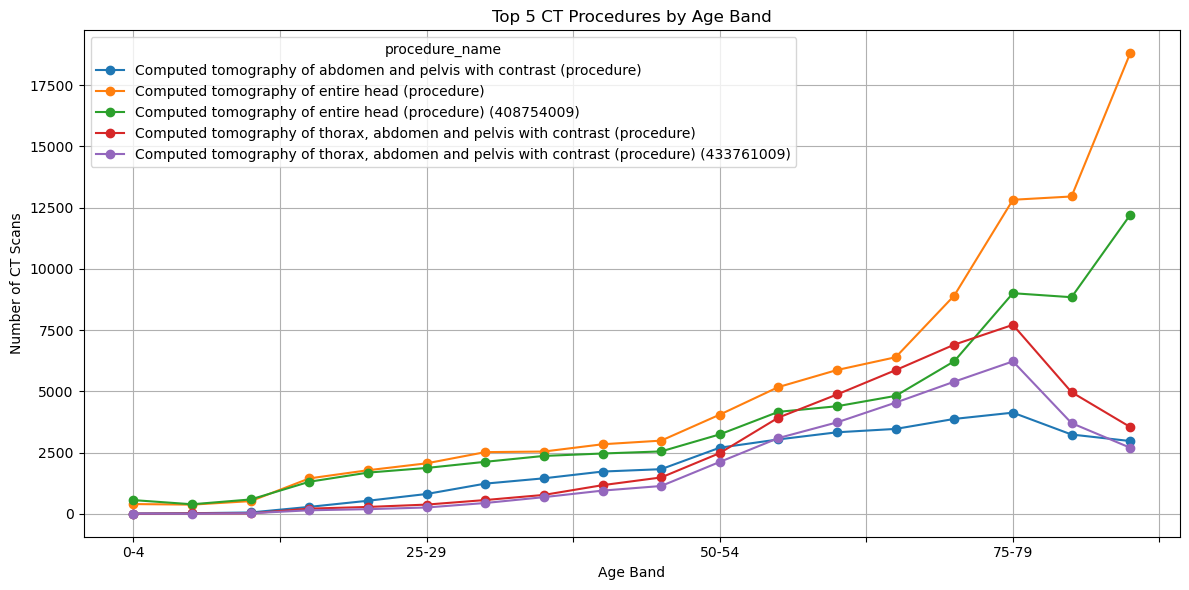

In [17]:
# ---------------------------------------------------
# Step 3 – Line plot: Top 5 CT procedures by age_band
# ---------------------------------------------------
import matplotlib.pyplot as plt  # ✅ Ensure this is imported

# Identify top 5 CT procedures overall
top_5_ct_procedures = (
    df_ct["procedure_name"]
    .value_counts()
    .head(5)
    .index
)

# Crosstab for just the top 5
ct_plot = pd.crosstab(
    df_ct[df_ct["procedure_name"].isin(top_5_ct_procedures)]["age_band"],
    df_ct["procedure_name"]
)


# Plot
ct_plot.plot(
    kind='line', marker='o', figsize=(12, 6),
    title="Top 5 CT Procedures by Age Band"
)

plt.xlabel("Age Band")
plt.ylabel("Number of CT Scans")
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
# ---------------------------------------------------
# Step 4 – CT Procedure vs Patient Source (Sorted)
# ---------------------------------------------------

# Create crosstab with procedure_name as rows, ps_bucket as columns
ct_ps = pd.crosstab(
    df_ct["procedure_name"],
    df_ct["ps_bucket"]
)

# Add total count column to sort
ct_ps["Total"] = ct_ps.sum(axis=1)

# Sort by total descending and drop the helper column
ct_ps_sorted = ct_ps.sort_values("Total", ascending=False).drop(columns="Total")

# Display top 100 procedures
display(
    ct_ps_sorted.head(10).style
        .set_caption("Top 100 CT Procedures by Patient Source")
        .background_gradient(cmap="Blues")
        .format(na_rep="–")
)

print(f"Patient source breakdown complete.")
print(f"Unique ps_buckets: {df_ct['ps_bucket'].nunique()}")
print(f"Total unique CT procedure types: {df_ct['procedure_name'].nunique()}")


ps_bucket,Emergency,GP,Inpatient,Other/Unknown,Outpatient
procedure_name,,,,,
Computed tomography of entire head (procedure),53034,5894,25226,1481,6991
Computed tomography of entire head (procedure) (408754009),38831,7493,19311,265,3222
"Computed tomography of thorax, abdomen and pelvis with contrast (procedure)",5170,2714,4997,136,32133
"Computed tomography of thorax, abdomen and pelvis with contrast (procedure) (433761009)",3405,3088,4718,96,24009
Computed tomography of abdomen and pelvis with contrast (procedure),9880,2493,13552,480,8263
Computed tomography of abdomen and pelvis with contrast (procedure) (432370003),8991,3721,13825,80,6141
Computed tomography of chest (procedure),1535,3283,1614,107,12549
Computed tomography of chest (procedure) (169069000),1096,5327,1306,37,8071
Computed tomography of abdomen and pelvis (procedure),1707,103,5745,861,2604


Patient source breakdown complete.
Unique ps_buckets: 5
Total unique CT procedure types: 537


In [25]:
# ---------------------------------------------------
# Step 5 – CT Procedure vs ICB Name (Top 100)
# ---------------------------------------------------
ct_icb = pd.crosstab(
    df_ct["procedure_name"],
    df_ct["icb_name"]
)

# Sort by total volume and keep top 100 procedures
ct_icb["Total"] = ct_icb.sum(axis=1)
ct_icb_sorted = ct_icb.sort_values("Total", ascending=False).drop(columns="Total")
ct_icb_top100 = ct_icb_sorted.head(10)

# Display
display(
    ct_icb_top100.style
        .set_caption("Top 100 CT Procedures by ICB")
        .background_gradient(cmap="Purples")
        .format(na_rep="–")
)

print(f"Unique ICBs: {df_ct['icb_name'].nunique()}")


icb_name,"NHS BATH AND NORTH EAST SOMERSET, SWINDON AND WILTSHIRE ICB - 92G","NHS BRISTOL, NORTH SOMERSET AND SOUTH GLOUCESTERSHIRE ICB - 15C",NHS CORNWALL AND THE ISLES OF SCILLY ICB - 11N,NHS DEVON ICB - 15N,NHS DORSET ICB - 11J,NHS GLOUCESTERSHIRE ICB - 11M,NHS SOMERSET ICB - 11X
procedure_name,,,,,,,
Computed tomography of entire head (procedure),28393,899,14094,11294,22674,8148,7124
Computed tomography of entire head (procedure) (408754009),1583,34453,3482,15389,229,3282,10704
"Computed tomography of thorax, abdomen and pelvis with contrast (procedure)",15038,318,9402,6906,4757,4654,4075
"Computed tomography of thorax, abdomen and pelvis with contrast (procedure) (433761009)",505,14674,2149,9854,100,561,7473
Computed tomography of abdomen and pelvis with contrast (procedure),11897,455,6070,4048,4257,4198,3743
Computed tomography of abdomen and pelvis with contrast (procedure) (432370003),509,15955,1528,8365,91,715,5595
Computed tomography of chest (procedure),9157,129,2296,1904,3463,1573,566
Computed tomography of chest (procedure) (169069000),198,9555,854,4441,26,354,409
Computed tomography of abdomen and pelvis (procedure),1866,16,232,313,8119,353,121


Unique ICBs: 7


In [42]:
# ---------------------------------------------------
# Step 6a – Inspect All Unique CT Procedure Names
# ---------------------------------------------------

# 1. Number of unique procedure names
n_unique_procs = df_ct["procedure_name"].nunique()
print(f"🔍 Unique CT procedure names: {n_unique_procs}\n")

# 2. Display full sorted list
ct_unique_procs = df_ct["procedure_name"].dropna().unique()
ct_unique_procs_sorted = sorted(ct_unique_procs)

for i, proc in enumerate(ct_unique_procs_sorted, 1):
    print(f"{i:3}. {proc}")


🔍 Unique CT procedure names: 537

  1. Ablation of osteoid osteoma using computed tomography guidance (procedure)
  2. Ablation using computed tomography guidance (procedure)
  3. Ablation using computed tomography guidance (procedure) (430269006)
  4. Aspiration using computed tomography guidance (procedure) (431749009)
  5. Biopsy of bone using computed tomography guidance (procedure)
  6. Biopsy of bone using computed tomography guidance (procedure) (432371004)
  7. Biopsy of kidney using computed tomography guidance (procedure) (438820000)
  8. Biopsy of left kidney using computed tomography guidance (procedure)
  9. Biopsy of left kidney using computed tomography guidance (procedure) (1391000087101)
 10. Biopsy of lung using computed tomography guidance (procedure)
 11. Biopsy of lung using computed tomography guidance (procedure) (429932001)
 12. Biopsy of right kidney using computed tomography guidance (procedure)
 13. Biopsy of thorax using computed tomography guidance (procedu

In [27]:
# ---------------------------------------------------
# Step 6b – Create CT Type Category (Head, Chest, etc.)
# ---------------------------------------------------

import re

# Define patterns for CT body region categorisation
ct_map = {
    r"\bhead\b|cranial|brain": "Head",
    r"\bchest\b|\bthorax\b|\blung\b|pleura": "Chest",
    r"\babdomen\b|\bpelvis\b|\bretroperitoneal\b": "Abdo/Pelvis",
    r"\bspine\b|\bvertebrae\b|lumbar|thoracic|cervical": "Spine",
    r"angiography|vascular|artery|vein|aorta|pulmonary": "Angio",
    r"\brenal\b|urinary|kidney|ureter|bladder": "Renal/Urinary",
    r"\bneck\b|larynx|pharynx|thyroid": "Neck",
    r"hip|knee|elbow|ankle|shoulder|wrist|foot|hand|limb|extremit": "Extremities",
    r"cardiac|heart|coronary": "Cardiac",
    r"\bwhole body\b|pan body|polytrauma": "Whole Body",
    r"\bsinus\b|nasal|orbit|face|facial": "Face/Sinus",
    r"dental|mandible|maxilla|orthopantomogram": "Dental",
    r"bowel|colon|appendix|intestin": "Bowel",
}

# Mapping function to assign CT type labels
def map_ct_type(name):
    for pattern, label in ct_map.items():
        if pd.notnull(name) and re.search(pattern, name.lower()):
            return label
    return "Other"

# Apply mapping to create new column
df_ct["ct_type"] = df_ct["procedure_name"].apply(map_ct_type)

# Display value counts including 'Other'
ct_type_counts = df_ct["ct_type"].value_counts(dropna=False).reset_index()
ct_type_counts.columns = ["CT Type", "Scan Count"]

display(
    ct_type_counts.style
        .set_caption("CT Scan Count by Anatomical Type (including 'Other')")
        .format({"Scan Count": "{:,}"})
        .background_gradient(cmap="Oranges", subset=["Scan Count"])
)

print(f"CT categorisation complete. Unique CT types assigned: {df_ct['ct_type'].nunique()}")
print(f"Total scans with 'Other' label: {df_ct['ct_type'].value_counts().get('Other', 0):,}")


,CT Type,Scan Count
0,Chest,"191,099"
1,Head,"185,663"
2,Abdo/Pelvis,"91,540"
3,Angio,"49,827"
4,Renal/Urinary,"37,022"
5,Spine,"22,013"
6,Other,"20,006"
7,Extremities,"16,197"
8,Bowel,"11,826"
9,Face/Sinus,"10,354"


CT categorisation complete. Unique CT types assigned: 14
Total scans with 'Other' label: 20,006


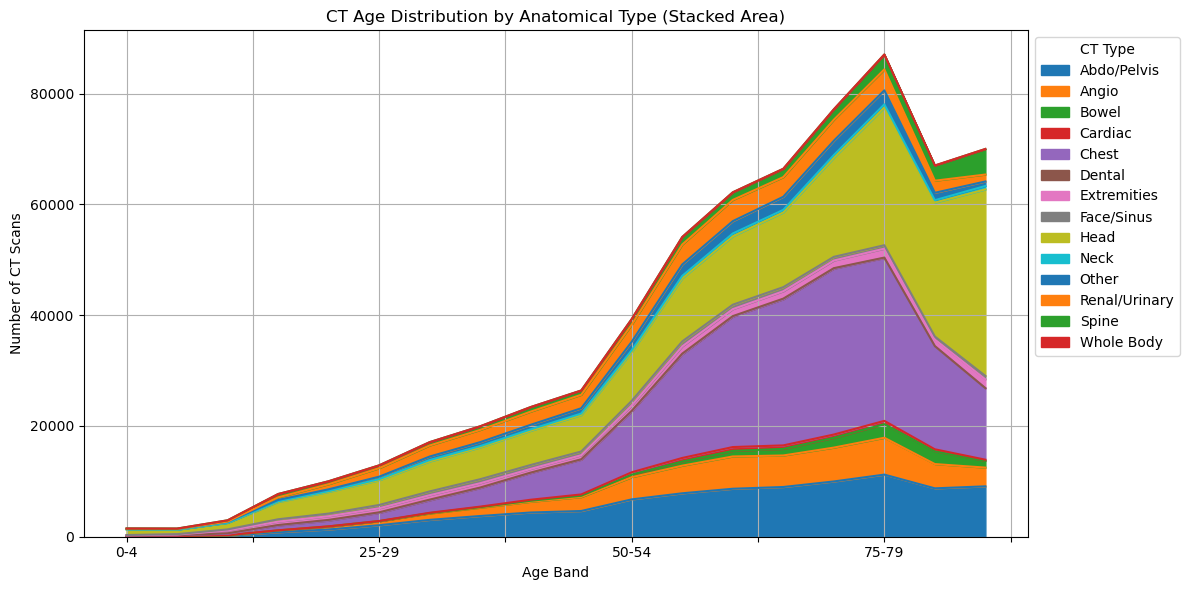

In [28]:
# ---------------------------------------------------
# Step 7a – CT Scan Age Distribution by Type (Stacked Area Chart)
# ---------------------------------------------------
sorted_bands = sorted(
    df_ct["age_band"].dropna().unique(),
    key=lambda x: int(str(x).split('-')[0].replace('+', ''))
)

# Crosstab: age_band × ct_type
ct_age_xtab = pd.crosstab(df_ct["age_band"], df_ct["ct_type"])
ct_age_xtab = ct_age_xtab.reindex(index=sorted_bands)

# Plot stacked area chart (absolute numbers)
fig, ax = plt.subplots(figsize=(12, 6))
ct_age_xtab.plot(kind="area", stacked=True, ax=ax)

ax.set_title("CT Age Distribution by Anatomical Type (Stacked Area)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Number of CT Scans")
ax.legend(title="CT Type", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


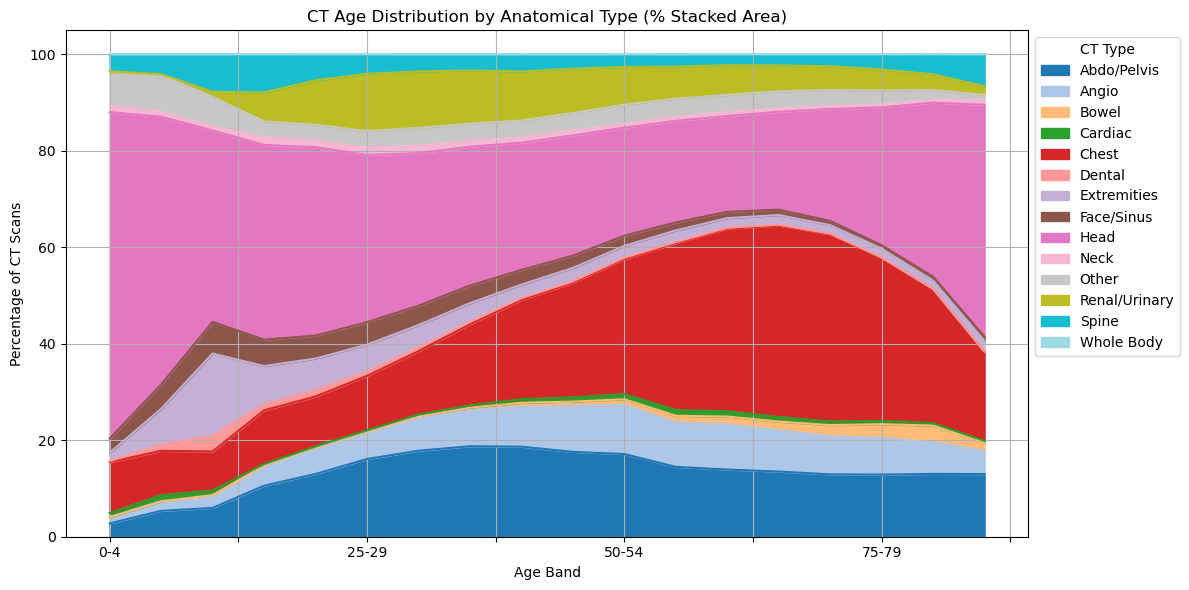

In [29]:
# ---------------------------------------------------
# Step 7b – CT Scan Age Distribution by Type (% Stacked Area Chart)
# ---------------------------------------------------
ct_age_xtab_pct = ct_age_xtab.div(ct_age_xtab.sum(axis=1), axis=0) * 100

# Plot stacked area chart (percentages)
fig, ax = plt.subplots(figsize=(12, 6))
ct_age_xtab_pct.plot(kind="area", stacked=True, cmap="tab20", ax=ax)

ax.set_title("CT Age Distribution by Anatomical Type (% Stacked Area)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Percentage of CT Scans")
ax.legend(title="CT Type", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()


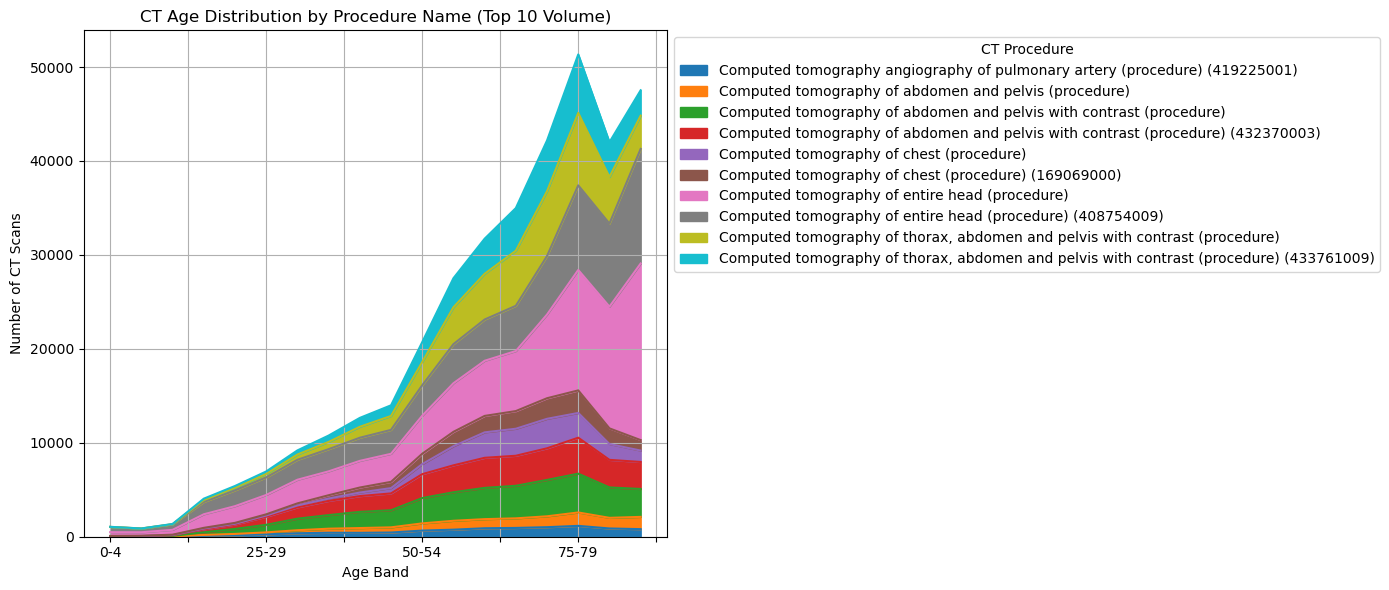

In [30]:
# ---------------------------------------------------
# Step 8a – CT Scan Age Distribution by Procedure Name (Top 10 Only)
# ---------------------------------------------------
top_10_ct_procs = df_ct["procedure_name"].value_counts().head(10).index.tolist()

ct_proc_xtab = pd.crosstab(
    df_ct[df_ct["procedure_name"].isin(top_10_ct_procs)]["age_band"],
    df_ct[df_ct["procedure_name"].isin(top_10_ct_procs)]["procedure_name"]
)

# Reorder age bands
sorted_bands = sorted(
    ct_proc_xtab.index.dropna(),
    key=lambda x: int(str(x).split('-')[0].replace('+', ''))
)
ct_proc_xtab = ct_proc_xtab.reindex(index=sorted_bands)

# Plot stacked area chart (volume)
fig, ax = plt.subplots(figsize=(14, 6))
ct_proc_xtab.plot(kind="area", stacked=True, ax=ax)

ax.set_title("CT Age Distribution by Procedure Name (Top 10 Volume)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Number of CT Scans")
ax.legend(title="CT Procedure", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)# ---------------------------------------------------
# Step 8b – CT Scan Age Distribution by Procedure Name (% Stacked Area, Top 10)
# ---------------------------------------------------
ct_proc_xtab_pct = ct_proc_xtab.div(ct_proc_xtab.sum(axis=1), axis=0) * 100

# Plot percentage stacked area chart
fig, ax = plt.subplots(figsize=(14, 6))
ct_proc_xtab_pct.plot(kind="area", stacked=True, cmap="tab10", ax=ax)

ax.set_title("CT Age Distribution by Procedure Name (% Stacked Area, Top 10)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Percentage of CT Scans")
ax.legend(title="CT Procedure", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()


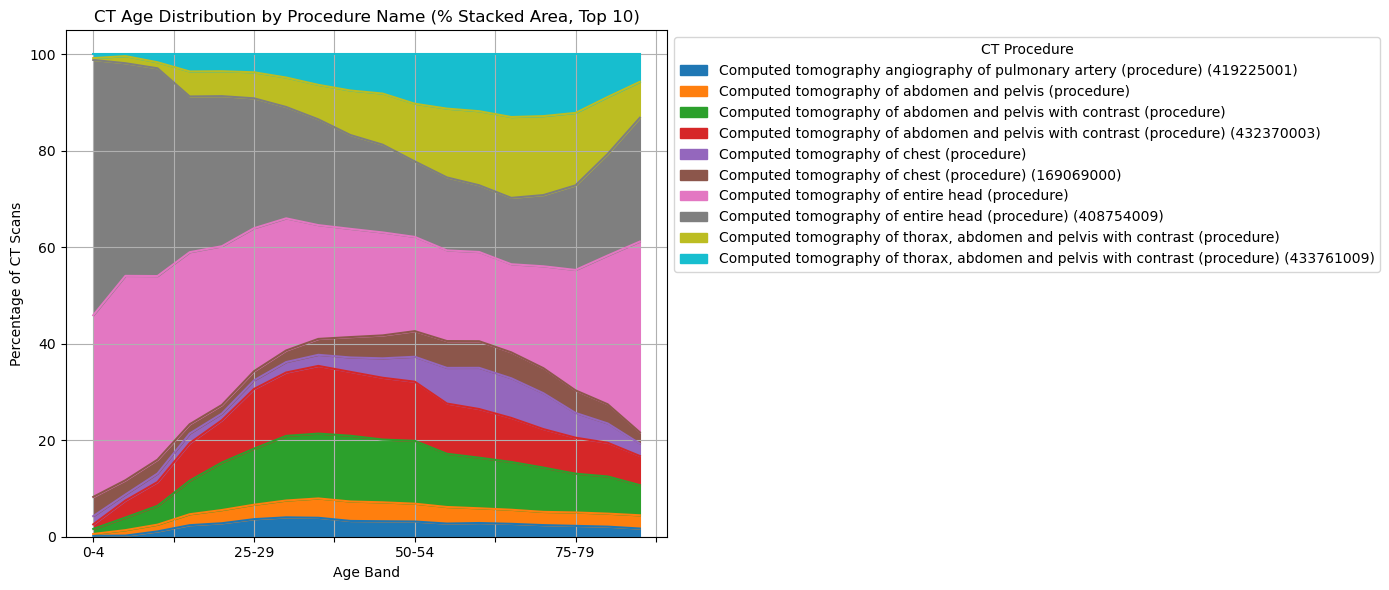

In [31]:
# ---------------------------------------------------
# Step 8b – CT Scan Age Distribution by Procedure Name (% Stacked Area, Top 10)
# ---------------------------------------------------
ct_proc_xtab_pct = ct_proc_xtab.div(ct_proc_xtab.sum(axis=1), axis=0) * 100

# Plot percentage stacked area chart
fig, ax = plt.subplots(figsize=(14, 6))
ct_proc_xtab_pct.plot(kind="area", stacked=True, cmap="tab10", ax=ax)

ax.set_title("CT Age Distribution by Procedure Name (% Stacked Area, Top 10)")
ax.set_xlabel("Age Band")
ax.set_ylabel("Percentage of CT Scans")
ax.legend(title="CT Procedure", loc="upper left", bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()
